In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Concatenate, Dense
from tensorflow.keras.optimizers import Adam

# Load pre-trained models
cnn_model = load_model('/content/drive/MyDrive/Model/best_cnn_model1.h5')
mobilenet_model = load_model('/content/drive/MyDrive/Model/best_mobilenet_model1.h5')
vgg_model = load_model('/content/drive/MyDrive/Model/best_vgg16_model(2).h5')

# Function to rename model layers
def rename_model_layers(model, prefix):
    for layer in model.layers:
        layer._name = prefix + '_' + layer.name

# Rename layers to ensure uniqueness
rename_model_layers(cnn_model, 'cnn')
rename_model_layers(mobilenet_model, 'mobilenet')
rename_model_layers(vgg_model, 'vgg')




In [ ]:
from tensorflow.keras.layers import Input, Lambda, concatenate, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

input_shape = (224, 224, 3)  # Chosen to match MobileNet and VGG
common_input = Input(shape=input_shape)
weight_cnn = 1.0
weight_mobilenet = 1.0
weight_vgg = 2.0

# Resize images for the CNN model within the model using a Lambda layer
resize_images = Lambda(lambda image: tf.image.resize(image, (64, 64)))(common_input)

# Connect each model to the input layer
cnn_output = cnn_model(resize_images)  # CNN expects (64, 64, 3)
mobilenet_output = mobilenet_model(common_input)  # MobileNet expects (224, 224, 3)
vgg_output = vgg_model(common_input)  # VGG expects (224, 224, 3)
weighted_vgg_output = Lambda(lambda x: x * weight_vgg)(vgg_output)
# Concatenate outputs from all three models
concatenated_outputs = concatenate([cnn_output,mobilenet_output, weighted_vgg_output])

# Add a Dense layer on top if needed
final_output = Dense(4, activation='softmax')(concatenated_outputs)  # Assuming 4 classes

# Create the fused model
fused_model = Model(inputs=common_input, outputs=final_output)
fused_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
fused_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 64, 64, 3)            0         ['input_1[0][0]']             
                                                                                                  
 sequential (Sequential)     (None, 4)                    1589664   ['input_1[0][0]']             
                                                          4                                       
                                                                                                  
 sequential_3 (Sequential)   (None, 4)                    1625668   ['lambda[0][0]']          

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/preprocessed_ECG_images",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/preprocessed_ECG_images",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset='validation'
)


Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks setup with the new save format
checkpoint = ModelCheckpoint(
    "fused_model1.tf",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_format='tf'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Training the model
history = fused_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr, early_stop]
)


Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.1107 - accuracy: 0.5383
Epoch 1: val_accuracy improved from -inf to 0.45902, saving model to fused_model1.tf
24/24 [==============================] - 203s 8s/step - loss: 1.1107 - accuracy: 0.5383 - val_loss: 1.3033 - val_accuracy: 0.4590 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.9279 - accuracy: 0.7503
Epoch 2: val_accuracy improved from 0.45902 to 0.60109, saving model to fused_model1.tf
24/24 [==============================] - 45s 2s/step - loss: 0.9279 - accuracy: 0.7503 - val_loss: 1.0648 - val_accuracy: 0.6011 - lr: 0.0010
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.8292 - accuracy: 0.7973
Epoch 3: val_accuracy improved from 0.60109 to 0.71585, saving model to fused_model1.tf
24/24 [==============================] - 43s 2s/step - loss: 0.8292 - accuracy: 0.7973 - val_loss: 0.9671 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 4/50
24/24 [============

In [ ]:
fused_model.save("/content/drive/MyDrive/Model/fused_model1")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalization only for evaluation
datagen = ImageDataGenerator(rescale=1./255)
cnn_test_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/preprocessed_ECG_images/",  # Update with your path
    target_size=(64, 64),  # CNN model expects (64, 64)
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No shuffling for evaluation
)
vgg_test_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/preprocessed_ECG_images/",
    target_size=(224, 224),  # VGG and MobileNet expect (224, 224)
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No shuffling for evaluation
)


fused_model = load_model('/content/drive/MyDrive/Model/fused_model1')

Found 928 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


29/29 [==============================] - 11s 337ms/step
Classification Report:
                    precision    recall  f1-score   support

Abnormal heartbeat       0.99      0.91      0.95       233
     History of MI       0.95      0.95      0.95       172
       MI Patients       0.97      1.00      0.99       239
            Normal       0.96      0.99      0.98       284

          accuracy                           0.97       928
         macro avg       0.97      0.97      0.97       928
      weighted avg       0.97      0.97      0.97       928



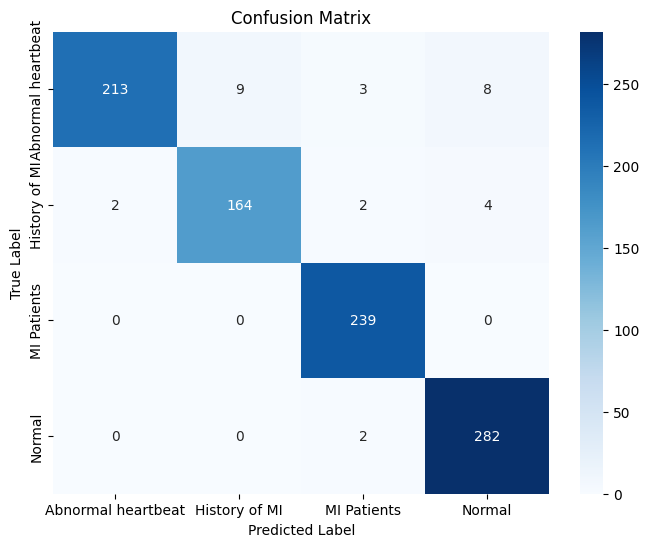

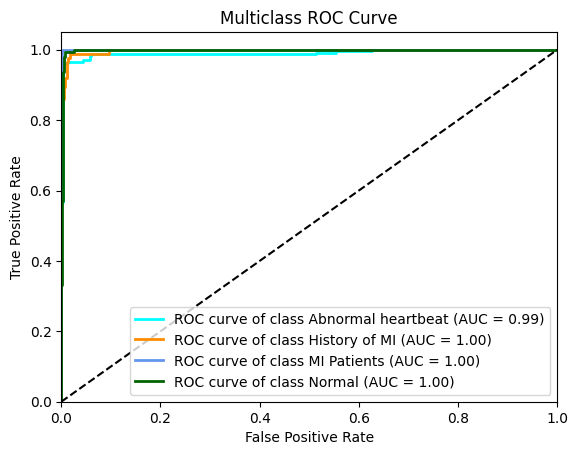

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
import seaborn as sns
from itertools import cycle

# Load the fused model
fused_model_path = '/content/drive/MyDrive/Model/fused_model1'
fused_model = tf.keras.models.load_model(fused_model_path)

# Define the evaluation function
def evaluate_fused_model(model, test_generator, steps):
    # Predict probabilities on the test generator
    y_pred_prob = model.predict(test_generator, steps=steps)

    # Get true labels from the test generator
    y_true = test_generator.classes

    # Calculate classification report
    report = classification_report(y_true, np.argmax(y_pred_prob, axis=1), target_names=list(test_generator.class_indices.keys()))

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, np.argmax(y_pred_prob, axis=1))

    return y_pred_prob, y_true, report, cm

# Function to plot ROC curve for each class
def plot_multiclass_roc(y_true, y_pred_prob, class_names):
    n_classes = len(class_names)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_prob[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Assuming your test generator is set up and uses images of size (224, 224)
test_generator = vgg_test_generator  # Adjust according to your setup

# Evaluate the fused model
steps = test_generator.samples // test_generator.batch_size
y_pred_prob, y_true, report, cm = evaluate_fused_model(fused_model, test_generator, steps)

# Display classification report
print("Classification Report:")
print(report)

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

class_names = list(test_generator.class_indices.keys())
plot_confusion_matrix(cm, class_names)

# Plot ROC curves for each class
plot_multiclass_roc(y_true, y_pred_prob, class_names)


In [ ]:
!pip install gradio

In [ ]:
import numpy as np
import gradio as gr
from PIL import Image
from skimage import color, filters
from tensorflow.keras.models import load_model

# Load the fused model
model_path = "/content/drive/MyDrive/fused_model1"
weight_vgg = 2.0
fused_model = load_model(model_path)

# Classes the model predicts
classes = ['Abnormal heartbeat', 'History of MI', 'MI Patients', 'Normal']

# Function to preprocess image for the fused model
def preprocess_image(image_path):
    # Convert image to grayscale
    image = Image.open(image_path)

    # Dividing the ECG leads from 1-12 from the above image
    Leads = image.crop((150, 300, 2125, 1200))
    grayscale_image = color.rgb2gray(Leads)

    # Apply Gaussian blur
    blurred_image = filters.gaussian(grayscale_image, sigma=0.7)

    # Apply Otsu thresholding
    threshold = filters.threshold_otsu(blurred_image)
    binary_image = blurred_image < threshold

    # Resize image to match model input size
    target_size = (224, 224)
    resized_image = Image.fromarray(binary_image).resize(target_size)

    # Convert to RGB
    resized_image = resized_image.convert("RGB")

    # Convert image to numpy array and normalize
    resized_image = np.array(resized_image) / 255.0

    # Add batch dimension
    resized_image = np.expand_dims(resized_image, axis=0)

    return resized_image

# Function to make predictions
def predict(image):
    # Preprocess the image
    image = preprocess_image(image)

    # Get predictions from the fused model
    predictions = fused_model.predict(image)
    predicted_class_index = np.argmax(predictions, axis=1)
    predicted_class = classes[predicted_class_index[0]]
    confidence = np.max(predictions)

    # Format output string
    result = f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}"
    return result

# Gradio interface setup
iface = gr.Interface(fn=predict,
                     inputs=gr.Image(type="filepath", label="Upload ECG Image"),
                     outputs=gr.Text(label="Model Predictions"),
                     title="ECG Image Classification",
                     description="Predict the type of heart condition based on ECG images using a fused neural network model.")
iface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://07e14458c858504d00.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 25ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://07e14458c858504d00.gradio.live


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import gradio as gr
from PIL import Image
from skimage import color, filters
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam.utils import normalize
import tensorflow as tf

# Load the fused model
model_path = "/content/drive/MyDrive/fused_model1"
fused_model = load_model(model_path)

# Define classes the model predicts
classes = ['Abnormal heartbeat', 'History of MI', 'MI Patients', 'Normal']

# Function to preprocess image for the fused model
def preprocess_image(image_path):
    # Convert image to grayscale
    image = Image.open(image_path)

    # Crop the leads from the image
    leads = image.crop((150, 300, 2125, 1200))
    grayscale_image = color.rgb2gray(leads)

    # Apply Gaussian blur
    blurred_image = filters.gaussian(grayscale_image, sigma=0.7)

    # Apply Otsu thresholding
    threshold = filters.threshold_otsu(blurred_image)
    binary_image = blurred_image < threshold

    # Resize image to match model input size
    target_size = (224, 224)
    resized_image = Image.fromarray(binary_image).resize(target_size)

    # Convert to RGB
    resized_image = resized_image.convert("RGB")

    # Convert image to numpy array and normalize
    resized_image = np.array(resized_image) / 255.0

    # Add batch dimension
    resized_image = np.expand_dims(resized_image, axis=0)

    return resized_image

# Create an instance of Gradcam for the fused model
gradcam = Gradcam(fused_model, model_modifier=None)

# Function to generate saliency map
def generate_saliency_map(image_path):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Predict class index for the preprocessed image
    predictions = fused_model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Compute Grad-CAM heatmap
    heatmap = gradcam(score_index=predicted_class_index, input_data=preprocessed_image)
    heatmap = normalize(np.squeeze(heatmap))

    # Convert heatmap to PIL image
    heatmap_image = np.uint8(heatmap * 255)
    heatmap_pil_image = Image.fromarray(heatmap_image).convert('RGB')

    # Load the original image and blend with heatmap
    original_image = Image.open(image_path)
    overlayed_image = Image.blend(original_image, heatmap_pil_image, alpha=0.5)

    return overlayed_image

# Function to predict class and generate saliency map
def predict_and_saliency(image_path):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)

    # Get predictions from the fused model
    predictions = fused_model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = classes[predicted_class_index]
    confidence = predictions[0][predicted_class_index]

    # Generate saliency map
    saliency_map = generate_saliency_map(image_path)

    # Format the output
    result = f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}"
    return result, saliency_map

# Create Gradio interface
iface = gr.Interface(
    fn=predict_and_saliency,
    inputs=gr.Image(type="filepath", label="Upload ECG Image"),
    outputs=[
        gr.Text(label="Model Predictions"),
        gr.Image(label="Saliency Map")
    ],
    title="ECG Image Classification with Saliency Map",
    description="Predict the type of heart condition based on ECG images using a fused neural network model, and visualize important regions using Grad-CAM."
)

# Launch the interface
iface.launch(debug=True)
